# Explore Dataset

Downloading: https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Downloading: https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Downloading: https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
Downloading: https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz

✔ MNIST Loaded Successfully!
Train images: (60000, 784)
Train labels: (60000,)
Test images: (10000, 784)
Test labels: (10000,)

Label Distribution (Training Set):
Label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64


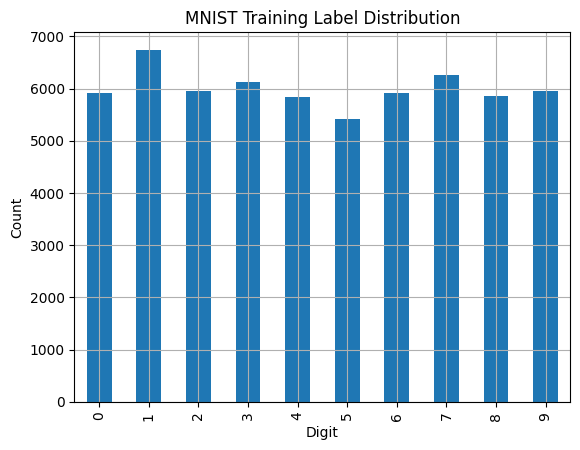

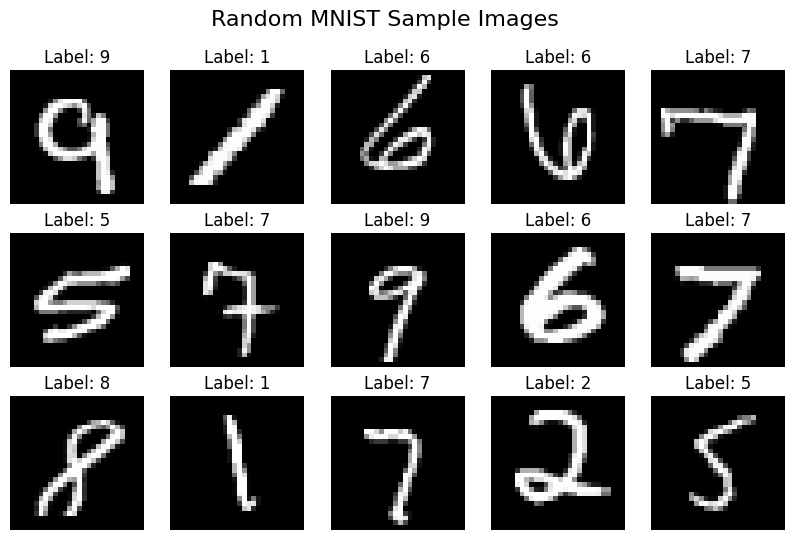

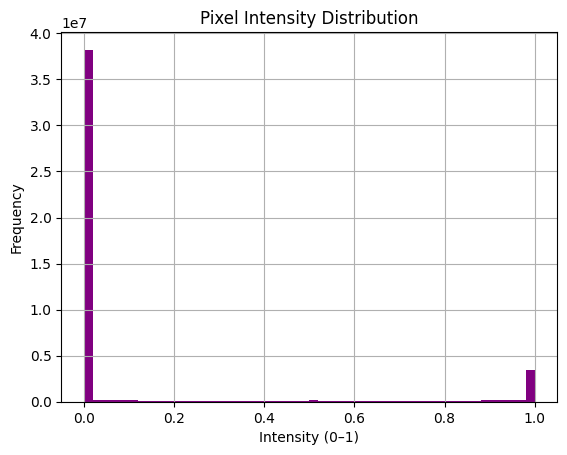

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import urllib.request

# ============================================================
# WORKING MNIST DOWNLOAD FUNCTION (Uses Google's mirror)
# ============================================================

def download_and_parse_mnist(url, is_images=True):
    print("Downloading:", url)

    # Download to local file
    filename = url.split("/")[-1]
    urllib.request.urlretrieve(url, filename)

    # Extract gzip file
    with gzip.open(filename, "rb") as f:
        data = f.read()

    # Skip header bytes
    if is_images:
        # First 16 bytes = header
        data = np.frombuffer(data, dtype=np.uint8, offset=16)
        # Reshape to (N, 28*28)
        return data.reshape(-1, 28*28) / 255.0
    else:
        # First 8 bytes = header
        return np.frombuffer(data, dtype=np.uint8, offset=8)

# ============================================================
# DOWNLOAD FROM A WORKING MIRROR
# ============================================================

base = "https://storage.googleapis.com/cvdf-datasets/mnist/"

train_x = download_and_parse_mnist(base + "train-images-idx3-ubyte.gz", is_images=True)
train_y = download_and_parse_mnist(base + "train-labels-idx1-ubyte.gz", is_images=False)

test_x = download_and_parse_mnist(base + "t10k-images-idx3-ubyte.gz", is_images=True)
test_y = download_and_parse_mnist(base + "t10k-labels-idx1-ubyte.gz", is_images=False)

print("\n✔ MNIST Loaded Successfully!")
print("Train images:", train_x.shape)
print("Train labels:", train_y.shape)
print("Test images:", test_x.shape)
print("Test labels:", test_y.shape)

# ============================================================
# USE PANDAS TO EXPLORE LABELS
# ============================================================

train_labels_pd = pd.Series(train_y, name="Label")

print("\nLabel Distribution (Training Set):")
print(train_labels_pd.value_counts())

# Plot label distribution
train_labels_pd.value_counts().sort_index().plot(kind='bar')
plt.title("MNIST Training Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ============================================================
# SHOW RANDOM SAMPLE IMAGES
# ============================================================

def show_sample_images(images, labels, rows=3, cols=5):
    plt.figure(figsize=(10, 6))
    for i in range(rows * cols):
        idx = np.random.randint(0, images.shape[0])
        img = images[idx].reshape(28, 28)
        label = labels[idx]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.suptitle("Random MNIST Sample Images", fontsize=16)
    plt.show()

show_sample_images(train_x, train_y)

# ============================================================
# Explore Pixel Intensity Distribution
# ============================================================

all_pixels = train_x.flatten()

plt.hist(all_pixels, bins=50, color="purple")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Intensity (0–1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Final

Loading MNIST...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training with SGD
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7180 - loss: 1.0841 - val_accuracy: 0.9153 - val_loss: 0.3226
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.3749 - val_accuracy: 0.9305 - val_loss: 0.2597
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9109 - loss: 0.3152 - val_accuracy: 0.9368 - val_loss: 0.2293
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9203 - loss: 0.2817 - val_accuracy: 0.9420 - val_loss: 0.2079
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9271 - loss: 0.2572 - val_accuracy: 0.9488 - val_loss: 0.1913

Training with Momentum
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8434 - loss: 0.5355 - val_accuracy: 0.9613 - val_loss: 0.1483
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9473 - loss: 0.1792 - val_accuracy: 0.9695 - val

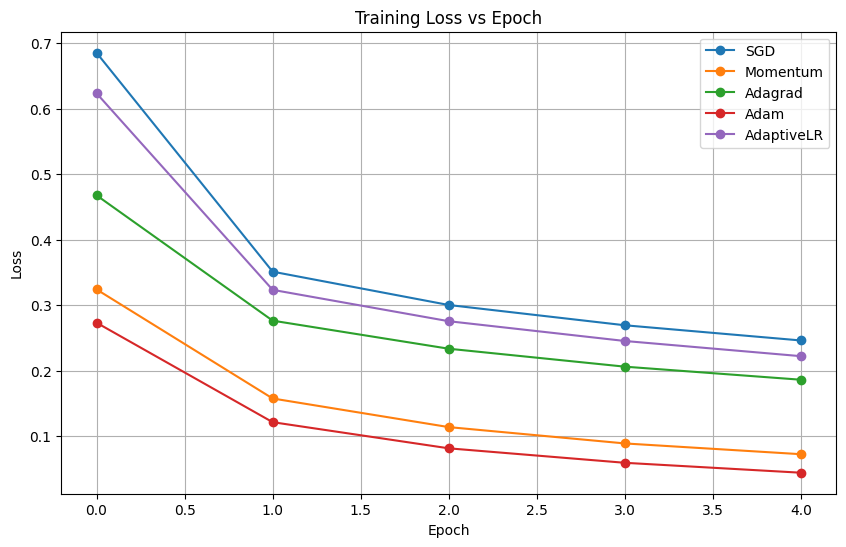

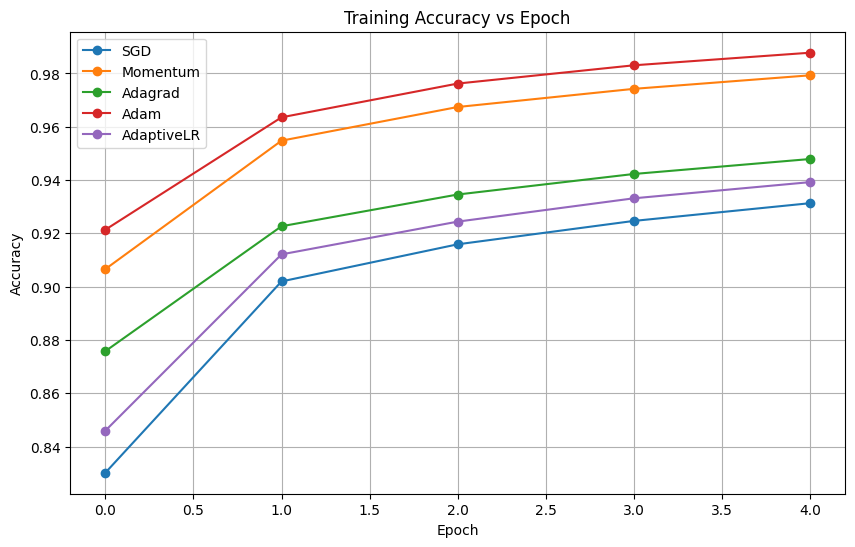

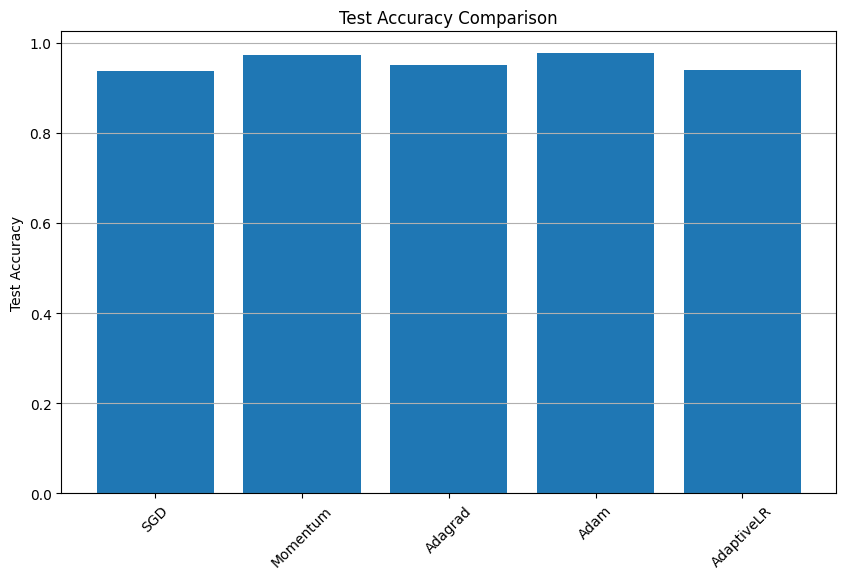

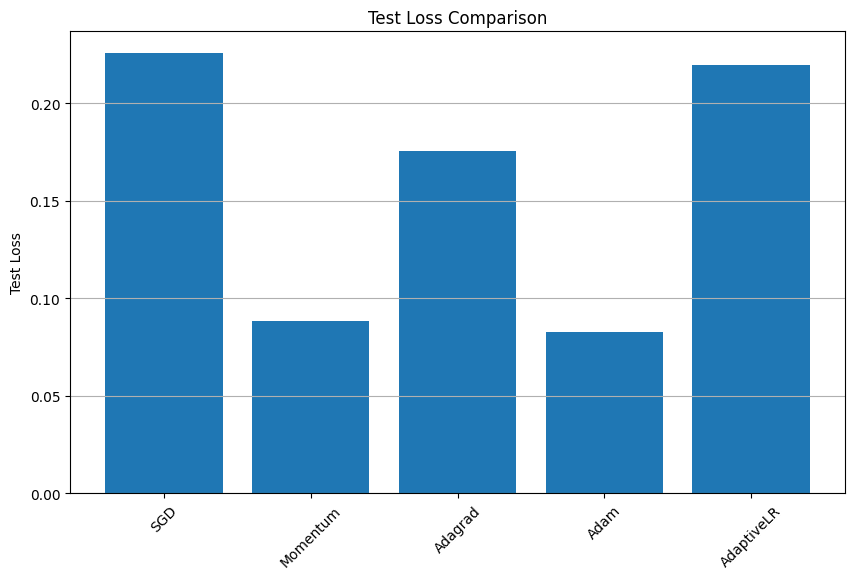

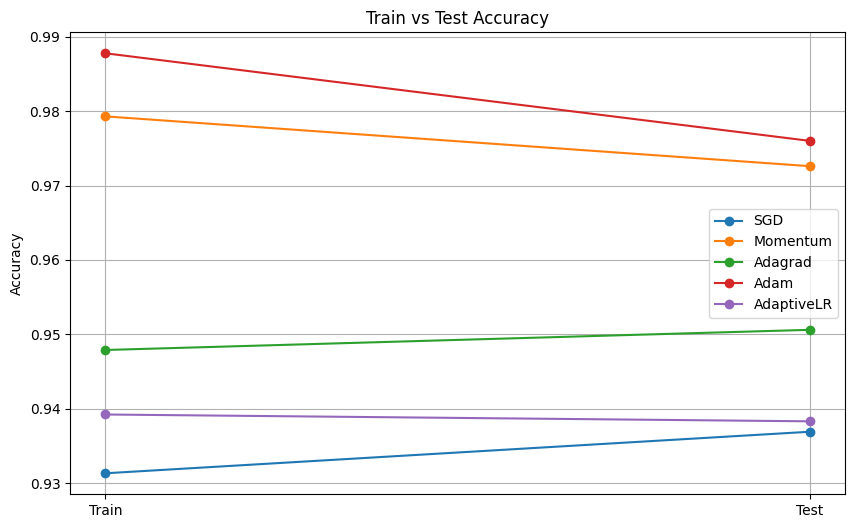

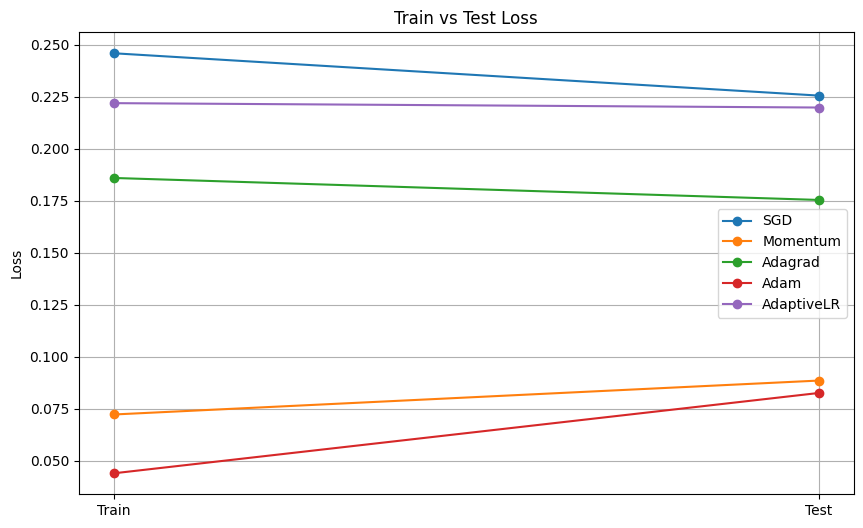

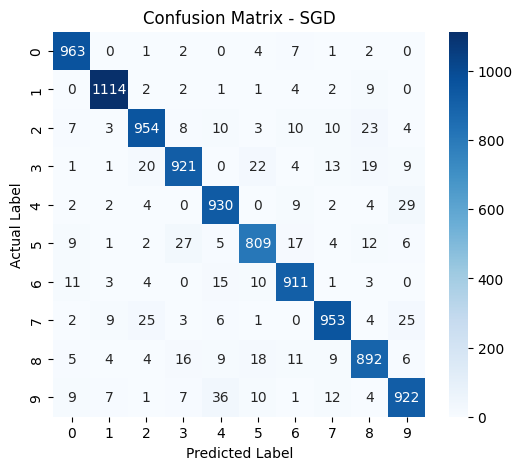

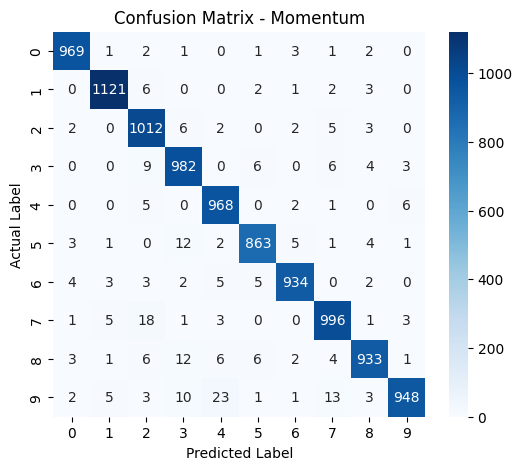

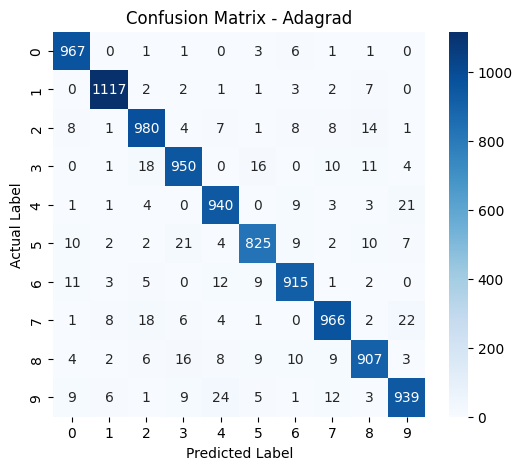

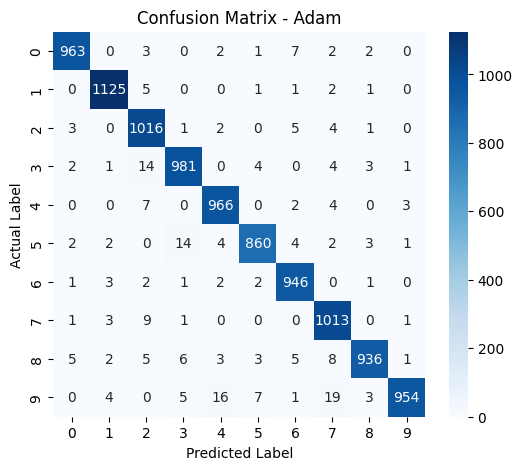

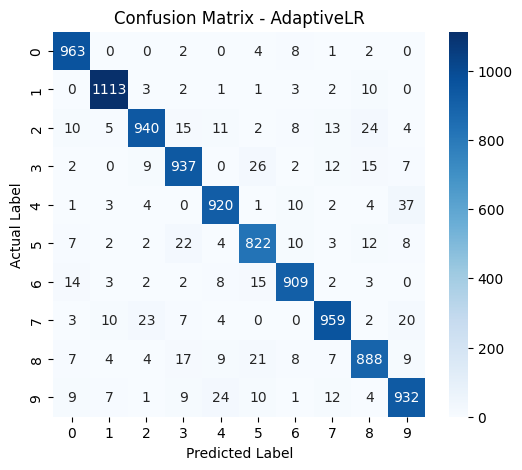

In [ ]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

tf.get_logger().setLevel('ERROR')

# For reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# ------------------------------------------------------------
# 1. LOAD & PREPROCESS MNIST
# ------------------------------------------------------------
print("Loading MNIST...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 784)
x_test  = x_test.reshape(-1, 784)

# ------------------------------------------------------------
# 2. MODEL FACTORY (784 → 128 → 10)
# ------------------------------------------------------------
def create_model():
    return keras.Sequential([
        keras.layers.InputLayer(shape=(784,), name="input"),
        keras.layers.Dense(128, activation="relu", name="hidden"),
        keras.layers.Dense(10, activation="softmax", name="output")
    ])

EPOCHS = 5
BATCH_SIZE = 32
VAL_SPLIT = 0.1
results = {}

# ------------------------------------------------------------
# 3. Helper function to train with Keras optimizer
# ------------------------------------------------------------
def train_with_optimizer(name, optimizer):
    print(f"\n==============================")
    print(f"Training with {name}")
    print(f"==============================")

    model = create_model()
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    start = time.time()
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VAL_SPLIT,
        verbose=1
    )
    end = time.time()

    # Predictions for test set
    test_logits = model.predict(x_test, verbose=0)
    test_pred = np.argmax(test_logits, axis=1)

    # Loss + accuracy
    test_loss = keras.losses.sparse_categorical_crossentropy(y_test, test_logits).numpy().mean()
    test_acc = np.mean(test_pred == y_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)

    results[name] = {
        "model": model,
        "history": history.history,
        "train_time": end - start,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "confusion_matrix": cm
    }

# ------------------------------------------------------------
# 4. Train built-in optimizers
# ------------------------------------------------------------
train_with_optimizer("SGD", keras.optimizers.SGD(learning_rate=0.01))
train_with_optimizer("Momentum", keras.optimizers.SGD(learning_rate=0.01, momentum=0.9))
train_with_optimizer("Adagrad", keras.optimizers.Adagrad(learning_rate=0.01))
train_with_optimizer("Adam", keras.optimizers.Adam(learning_rate=0.001))

# ------------------------------------------------------------
# 5. CUSTOM: ADAPTIVE LR USING LINEAR SEARCH
# ------------------------------------------------------------
print("\n==============================")
print("Training with Adaptive LR (Linear Search)")
print("==============================")

adaptive_model = create_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

candidate_lrs = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE)

history_adaptive_loss = []
history_adaptive_acc = []

start_adapt = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    epoch_losses = []
    train_acc_metric.reset_state()

    for step, (x_batch, y_batch) in enumerate(train_ds):

        with tf.GradientTape() as tape:
            logits = adaptive_model(x_batch, training=True)
            loss_value = loss_fn(y_batch, logits)
        grads = tape.gradient(loss_value, adaptive_model.trainable_variables)

        original_weights = adaptive_model.get_weights()

        best_lr = None
        best_loss = None

        for lr in candidate_lrs:
            adaptive_model.set_weights(original_weights)

            for var, g in zip(adaptive_model.trainable_variables, grads):
                var.assign_sub(lr * g)

            tmp_logits = adaptive_model(x_batch, training=True)
            tmp_loss = loss_fn(y_batch, tmp_logits).numpy()

            if best_loss is None or tmp_loss < best_loss:
                best_loss = tmp_loss
                best_lr = lr

        adaptive_model.set_weights(original_weights)
        for var, g in zip(adaptive_model.trainable_variables, grads):
            var.assign_sub(best_lr * g)

        epoch_losses.append(best_loss)
        train_acc_metric.update_state(y_batch, adaptive_model(x_batch, training=False))

        if step % 200 == 0:
            print(f"  step {step}: best_lr={best_lr:.5f}, batch_loss={best_loss:.4f}")

    history_adaptive_loss.append(np.mean(epoch_losses))
    history_adaptive_acc.append(train_acc_metric.result().numpy())

end_adapt = time.time()
adaptive_time = end_adapt - start_adapt

test_logits = adaptive_model(x_test, training=False)
test_pred = np.argmax(test_logits, axis=1)

test_loss_adaptive = loss_fn(y_test, test_logits).numpy().mean()
test_acc_adaptive = np.mean(test_pred == y_test)
cm_adaptive = confusion_matrix(y_test, test_pred)

results["AdaptiveLR"] = {
    "model": adaptive_model,
    "history": {"loss": history_adaptive_loss, "accuracy": history_adaptive_acc},
    "train_time": adaptive_time,
    "test_loss": test_loss_adaptive,
    "test_acc": test_acc_adaptive,
    "confusion_matrix": cm_adaptive
}

# ------------------------------------------------------------
# 6. PRINT CONFUSION MATRICES (raw text)
# ------------------------------------------------------------
print("\n================ CONFUSION MATRICES ================\n")
for name, info in results.items():
    print(f"\n-------------- {name} --------------")
    print(info["confusion_matrix"])

# ------------------------------------------------------------
# 7. ORIGINAL TRAINING LOSS GRAPH
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
for name, info in results.items():
    plt.plot(info["history"]["loss"], marker='o', label=name)
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 8. ORIGINAL TRAINING ACCURACY GRAPH
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
for name, info in results.items():
    if "accuracy" in info["history"]:
        plt.plot(info["history"]["accuracy"], marker='o', label=name)
plt.title("Training Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 9. TEST ACCURACY BAR GRAPH
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
optimizers = list(results.keys())
test_accs = [results[name]["test_acc"] for name in optimizers]
plt.bar(optimizers, test_accs)
plt.title("Test Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# ------------------------------------------------------------
# 10. TEST LOSS BAR GRAPH
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
test_losses = [results[name]["test_loss"] for name in optimizers]
plt.bar(optimizers, test_losses)
plt.title("Test Loss Comparison")
plt.ylabel("Test Loss")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# ------------------------------------------------------------
# 11. TRAIN vs TEST ACCURACY
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
for name, info in results.items():
    train_acc = info["history"]["accuracy"][-1]
    test_acc = info["test_acc"]
    plt.plot([0,1], [train_acc, test_acc], marker='o', label=name)
plt.xticks([0,1], ["Train", "Test"])
plt.title("Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 12. TRAIN vs TEST LOSS
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
for name, info in results.items():
    train_loss = info["history"]["loss"][-1]
    test_loss = info["test_loss"]
    plt.plot([0,1], [train_loss, test_loss], marker='o', label=name)
plt.xticks([0,1], ["Train", "Test"])
plt.title("Train vs Test Loss")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 13. CONFUSION MATRIX HEATMAPS (LIKE YOUR PICTURE)
# ------------------------------------------------------------
for name, info in results.items():
    cm = info["confusion_matrix"]

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=[str(i) for i in range(cm.shape[0])],
        yticklabels=[str(i) for i in range(cm.shape[0])]
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# ========================= END OF SCRIPT =========================
